In [1]:
sys.path.insert(0, '../python')
import cool_tigress as ct

class PDR(object):
    
    def __init__(self, xmin=0.0, xmax=5.0, dx=0.02, 
                 nH=1e2, T=100.0,
                 G_PEi=1e1, G_H2i=1e1, G_CIi=1e1, G_COi=1e1,
                 xi_CR=1.0e-16, R_gr=3.0e-17, 
                 Z=1.0, kappa_PE=418.0,
                 b5=3.0, dvdr=1.0, 
                 solve=False):
        
        self.dvdr = 1.0
        self.gamma = 5.0/3.0
        self.muH = 1.4271*ac.m_p
        self.xmin = xmin
        self.xmax = xmax
        self.dx = dx
        self.dx_cm = (dx*au.pc).to('cm').value
        self.Nx = int((xmax - xmin)/dx)
        assert (xmax-xmin)/self.Nx == dx

        # Cell face coordinates
        self.xf = np.linspace(xmin, xmax, self.Nx + 1)
        # Cell center
        self.x = (self.xf + 0.5*dx)[:-1]

        self.xi_CR = xi_CR
        self.R_gr = R_gr
        self.b5 = b5
        
        # Metallicity
        self.Z = Z
        self.xCtot = 1.6e-4*self.Z
        
        # UV dust opacity
        self.kappa_PE = kappa_PE
        self.kappa_H2 = kappa_PE*4.18/1.87
        self.kappa_CI = kappa_PE*3.76/1.87
        self.kappa_CO = kappa_PE*3.88/1.87
        self.sigma_PE = (self.kappa_PE*au.cm**2/au.g*self.muH).to('cm**2').value
        self.sigma_H2 = (self.kappa_H2*au.cm**2/au.g*self.muH).to('cm**2').value
        self.sigma_CI = (self.kappa_CI*au.cm**2/au.g*self.muH).to('cm**2').value
        self.sigma_CO = (self.kappa_CO*au.cm**2/au.g*self.muH).to('cm**2').value
        
        # Unshielded H2 photodissociation rate scaled by ISRF (G_H2=1)
        self.zeta0 = 5.7e-11
        
        self.set_array(nH, T, G_PEi, G_H2i, G_CIi, G_COi)
        if solve:
            self.solve()

    def set_array(self, nH, T, G_PEi, G_H2i, G_CIi, G_COi):
        
        Nx = self.Nx
        self.nH = np.repeat(nH, Nx)
        self.nH2 = np.empty((Nx,))
        self.nCI = np.empty((Nx,))
        self.nCII = np.empty((Nx,))
        self.nCO = np.empty((Nx,))
        
        self.T = np.repeat(T, Nx)
        self.P = ((self.nH*self.T)*ac.k_B/au.cm**3*au.K).cgs.value
        self.E = 1.0/(self.gamma - 1.0)*self.P

        self.NHf = np.empty((Nx + 1,))
        self.NHf[0] = 0.0
        
        # H2 column and self-shielding factor
        self.NH2f = np.empty((Nx + 1,))
        self.NH2f[0] = 0.0
        self.fshld_H2f = np.empty((Nx + 1,))
        self.fshld_H2f[0] = 1.0

        # CI column and shielding factor
        self.NCIf = np.empty((Nx + 1,))
        self.NCIf[0] = 0.0
        self.fshld_CIf = np.empty((Nx + 1,))
        self.fshld_CIf[0] = 1.0
        
        # CO column and shielding factor
        self.NCOf = np.empty((Nx + 1,))
        self.NCOf[0] = 0.0
        self.fshld_COf = np.empty((Nx + 1,))
        self.fshld_COf[0] = 1.0
        
        # Fraction
        self.xe = np.empty((Nx,))
        self.xHI = np.empty((Nx,))
        self.xH2 = np.empty((Nx,))
        self.xCII = np.empty((Nx,))
        self.xCI = np.empty((Nx,))
        self.xCO = np.empty((Nx,))
        self.xOI = np.empty((Nx,))
        
        # Radiation field (at cell face)
        self.G_PEf = np.empty((Nx + 1,))
        # Dust only
        self.G_H2df = np.empty((Nx + 1,))
        self.G_CIdf = np.empty((Nx + 1,))
        self.G_COdf = np.empty((Nx + 1,))
        # With self-shielding
        self.G_H2f = np.empty((Nx + 1,))
        self.G_CIf = np.empty((Nx + 1,))
        self.G_COf = np.empty((Nx + 1,))
        
        self.G_PEf[0] = G_PEi
        self.G_H2df[0] = G_H2i
        self.G_CIdf[0] = G_CIi
        self.G_COdf[0] = G_COi
        self.G_H2f[0] = G_H2i
        self.G_CIf[0] = G_CIi
        self.G_COf[0] = G_COi
        
        self.crate = np.empty((Nx,))
        self.hrate = np.empty((Nx,))
    
    def solve_chem_rt(self):
        
        for i in range(self.Nx):
        # Update abundance
            xe, xHI, xH2, xCII, xCI, xCO, xOI = \
                ct.get_abundances(self.nH[i], self.T[i], self.dvdr, self.Z, self.xi_CR,
                                  self.G_PEf[i], self.G_CIf[i], self.G_COf[i], self.G_H2f[i])

            self.xe[i] = xe
            self.xHI[i] = xHI
            self.xH2[i] = xH2
            self.xCII[i] = xCII
            self.xCI[i] = xCI
            self.xCO[i] = xCO
            self.xOI[i] = xOI

            # Update NH, nH2, NH2, and f_shldH2
            self.NHf[i + 1] = self.NHf[i] + self.nH[i]*self.dx_cm
            self.nH2[i] = self.xH2[i]*self.nH[i]
            self.NH2f[i + 1] = self.NH2f[i] + self.nH2[i]*self.dx_cm
            self.fshld_H2f[i + 1] = self.calc_fshld_H2(self.NH2f[i + 1], self.b5)

            # Update nCO, nCI, NCI, and f_shldCI
            self.nCII[i] = self.xCII[i]*self.nH[i]
            self.nCI[i] = self.xCI[i]*self.nH[i]
            self.NCIf[i + 1] = self.NCIf[i] + self.nCI[i]*self.dx_cm
            self.fshld_CIf[i + 1] = self.calc_fshld_CI(self.NCIf[i + 1], self.NH2f[i + 1])

            self.nCO[i] = self.xCO[i]*self.nH[i]
            self.NCOf[i + 1] = self.NCOf[i] + self.nCO[i]*self.dx_cm
            self.fshld_COf[i + 1] = self.calc_fshld_CO(self.NCOf[i + 1], self.NH2f[i + 1])

            # Update radiation
            self.G_PEf[i + 1] = self.G_PEf[i]*np.exp(-self.nH[i]*self.dx_cm*self.sigma_PE)
            self.G_H2df[i + 1] = self.G_H2f[i]*np.exp(-self.nH[i]*self.dx_cm*self.sigma_H2)
            self.G_CIdf[i + 1] = self.G_CIf[i]*np.exp(-self.nH[i]*self.dx_cm*self.sigma_CI)
            self.G_COdf[i + 1] = self.G_COf[i]*np.exp(-self.nH[i]*self.dx_cm*self.sigma_CO)

            self.G_H2f[i + 1] = self.G_H2df[i + 1]*self.fshld_H2f[i]
            self.G_CIf[i + 1] = self.G_CIdf[i + 1]*self.fshld_CIf[i]
            self.G_COf[i + 1] = self.G_COdf[i + 1]*self.fshld_COf[i]

            self.crate[i] = ct.get_cooling(xe, xHI, xH2, xCII, xCI, xCO, xOI,
                                           self.nH[i], self.T[i], self.dvdr,
                                           self.Z, self.G_PEf[i])
            self.hrate[i] = ct.get_heating(xe, xHI, xH2,
                                           self.nH[i], self.T[i], self.Z, 
                                           self.xi_CR, self.G_PEf[i], self.G_H2f[i])
    
    @staticmethod
    def calc_xH2_equil(nH, xi_H = 2.0e-16, R_gr = 3.0e-17, zeta=5.7e-11):
        a = 2.31*xi_H
        b = -2.0*R_gr*nH - 4.95*xi_H - zeta
        c = nH*R_gr
        return (-b - np.sqrt(b**2 - 4.0*a*c))/(2.0*a)

    @staticmethod
    def calc_fshld_H2(NH2, b5):
        x = NH2/5.0e14
        return 0.965/(1.0 + x/b5)**2 + \
                  0.035/(1.0 + x)**0.5*np.exp(-8.5e-4*(1.0 + x)**0.5)
    
    @staticmethod
    def calc_fshld_CI(NCI, NH2):
        tau_H2 = 1.2e-14*2.0*NH2
        y = 1.17e-8*tau_H2
        return np.exp(-1.6e-17*NCI)*np.exp(-y)/(1.0 + y)

    @staticmethod
    def calc_fshld_CO(NCO, NH2):
        return ct.fShield_CO_V09_(NCO, NH2)

In [2]:
def plt_PDR(p):
    mpl.rcParams['font.size'] = 14
    mpl.rcParams['lines.markersize'] = 4
    fig = plt.figure(figsize=(18, 10))
    plt.subplot(231)
    plt.plot(p.NHf[1:], p.xH2, 'o-', label='H2')
    plt.plot(p.NHf[1:], p.xCI, 'o-', label='CI')
    plt.plot(p.NHf[1:], p.xCO, 'o-', label='CO')
    plt.plot(p.NHf[1:], p.xCII, 'o-', label='CII')
    plt.plot(p.NHf[1:], p.xe, 'o-', label='elec')
    plt.yscale('log')
    plt.legend(loc=3)
    plt.xscale('log')
    plt.ylabel('abundance')
    plt.ylim(1e-9,1)
    
    plt.subplot(234)
    plt.plot(p.xf, p.NH2f, 'o-', label='H2')
    plt.plot(p.xf, p.NCIf, 'o-', label='CI')
    plt.plot(p.xf, p.NCOf, 'o-', label='CO')
    plt.yscale('log')
    plt.ylabel('column density')

    plt.subplot(232)
    #x = p.xf
    x = p.NHf
    plt.plot(x, p.G_PEf, 'ko-', label='PE')
    l1, = plt.plot(x, p.G_H2f, 'o-', label='H2')
    l2, = plt.plot(x, p.G_CIf, 'o-', label='CI')
    l3, = plt.plot(x, p.G_COf, 'o-', label='CO')
    plt.plot(x, p.G_H2df, '--', label='H2dust', c=l1.get_color())
    plt.plot(x, p.G_CIdf, '--', label='CIdust', c=l2.get_color())
    plt.plot(x, p.G_COdf, '--', label='COdust', c=l3.get_color())
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-2, 2.0*p.G_PEf[0])
    plt.ylabel('Radiation field [G0]')
    plt.legend()

    plt.subplot(235)
    #x = p.xf
    x = p.NHf
    plt.plot(x, p.fshld_H2f, 'o-', label='H2')
    plt.plot(x, p.fshld_CIf, 'o-', label='CI')
    plt.plot(x, p.fshld_COf, 'o-', label='CO')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('shielding factor')
    plt.legend()

    plt.subplot(233)
    #x = p.xf
    x = p.NHf[1:]
    plt.plot(x, p.crate, 'o-', c='dodgerblue', label='cool')
    plt.plot(x, p.hrate, 'o-', c='orangered', label='heat')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('heating/cooling rates')
    plt.legend(loc=1)

    for i, ax in enumerate(fig.axes):
        if i == 1:
            ax.set_xlabel(r'$x\;[{\rm pc}]$')
        else:
            ax.set_xlabel(r'$N_{\rm H}\;[{\rm cm}^{-2}]$')

    
    plt.tight_layout()
    plt.suptitle(r'nH ' + str(p.nH[0]) + r' $\chi$ ' + str(p.G_PEf[0]))
    plt.subplots_adjust(top=0.93)

    return fig

## With xCO_max2

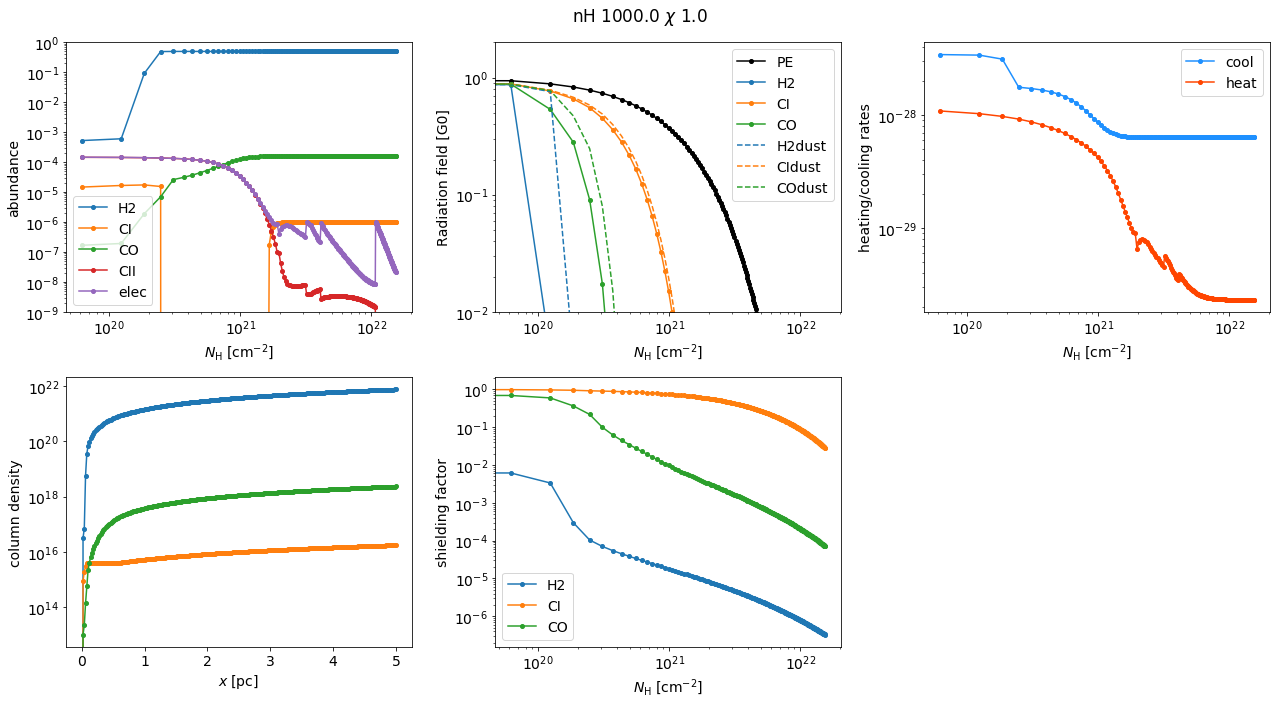

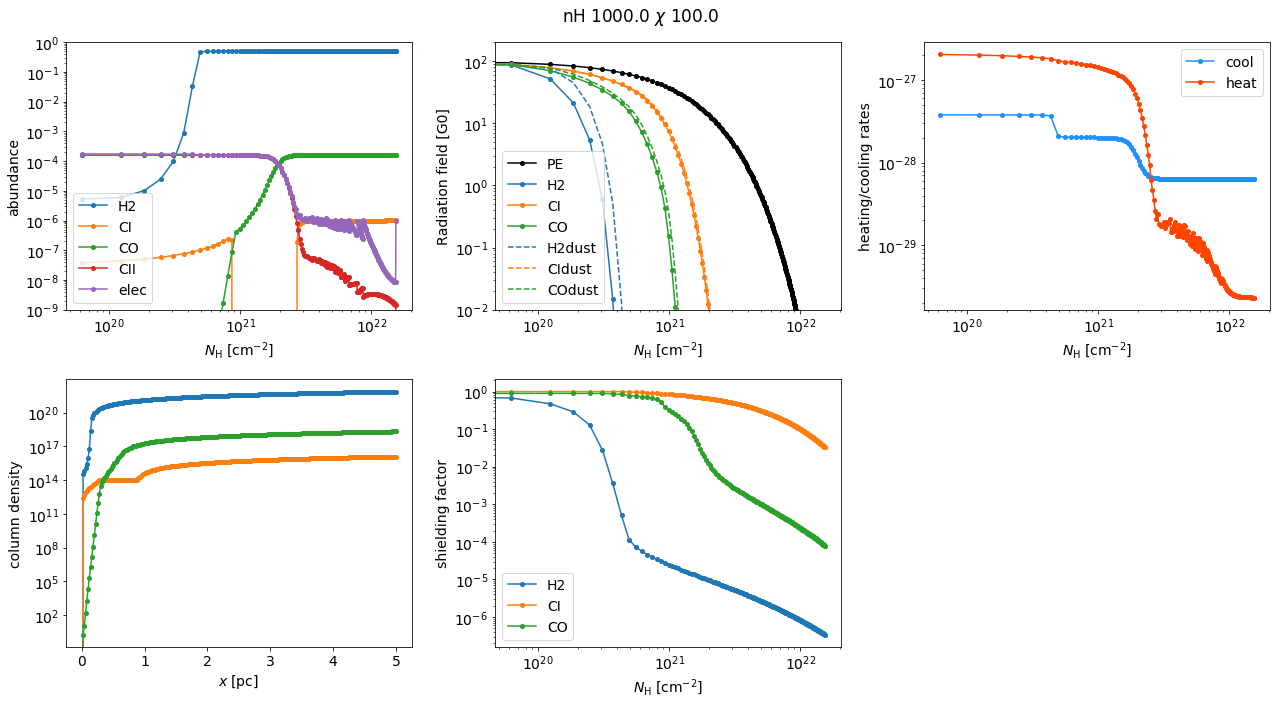

In [3]:
# def plt_PDR(p):
G0 = 1e0
T = 5e1
nH = 1e3
par = dict(nH=nH, T=T, G_PEi=G0,G_H2i=G0,G_CIi=G0,G_COi=G0)

p = PDR(**par)
p.solve_chem_rt()
fig1 = plt_PDR(p);
fig1.axes[0].set_ylim(1e-9,1)

G0 = 1e2
par = dict(nH=nH, T=T, G_PEi=G0,G_H2i=G0,G_CIi=G0,G_COi=G0)
p = PDR(**par)
p.solve_chem_rt()
fig2 = plt_PDR(p);

## Without xCO_max2

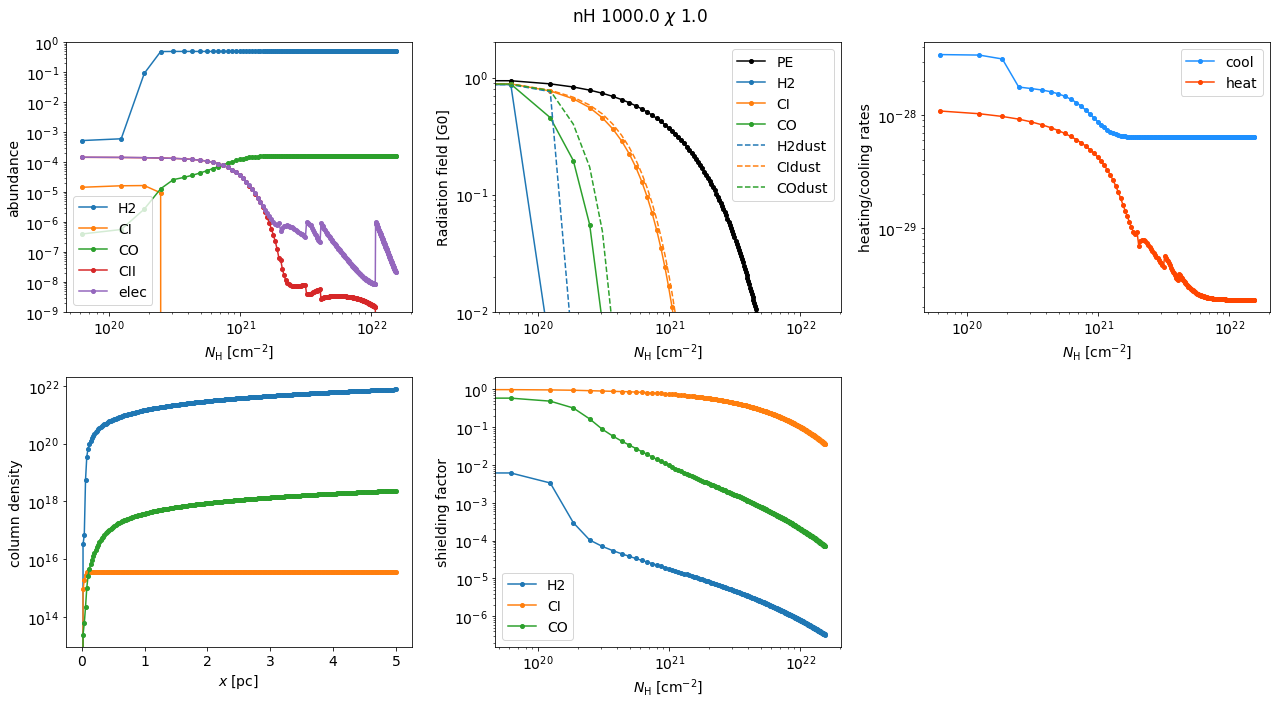

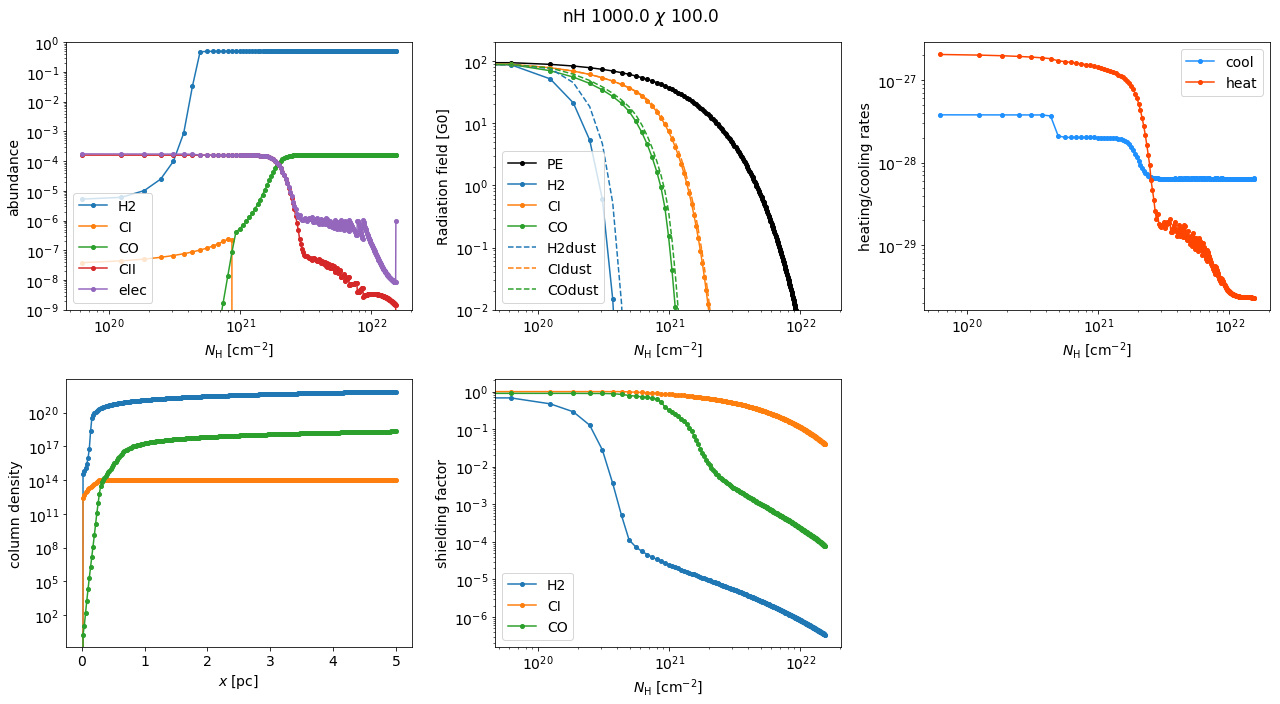

In [4]:
# def plt_PDR(p):
G0 = 1e0
T = 5e1
nH = 1e3
par = dict(nH=nH, T=T, G_PEi=G0,G_H2i=G0,G_CIi=G0,G_COi=G0)

p = PDR(**par)
p.solve_chem_rt()
fig1 = plt_PDR(p);
fig1.axes[0].set_ylim(1e-9,1)

G0 = 1e2
par = dict(nH=nH, T=T, G_PEi=G0,G_H2i=G0,G_CIi=G0,G_COi=G0)
p = PDR(**par)
p.solve_chem_rt()
fig2 = plt_PDR(p);